# Exercise sheet 11 - Parallelisation

# Exercise 1 - Rigged dice

Create a rigged dice function that 25% of the time returns the number 6. The rest of the time it returns the integers 1,2,3,4,5 uniformly.
Test your function, by calling it **one billion times** (10^9) and checking that 6 is returned in the range of 249-251 million (inclusive) times. You do not need to check that numbers 1 to 5 are returned uniformly or randomly, but you need to check that your function returns integers in the range 1-6 (inclusive). **Time** how long it takes to run the script.

Now attempt to **parallelise the task with a method of your own choosing** and time how long it takes once more. How does this compare to the previous *un-optimised* run?


In [5]:
import random
import time
import numpy as np

def rigged_dice():
    if random.random() < 0.25:  # 6 for 25% of the cases
        return 6
    else:
        return random.randint(1, 5)  # 1 to 5 for the other 75% of cases


# Test of the rigged dice
t0 = time.perf_counter()

N = 1000000000
count_six = 0
for _ in range(N):
    if rigged_dice() == 6:
        count_six += 1

print(f"Number of 6s: {count_six}")

# 6 in range?
if 249000000 <= count_six <= 251000000:
    print("The rigged dice worked!")
else:
    print("The rigged dice failed!")

t1 = time.perf_counter()
print("Time:", t1 - t0, "seconds")

Number of 6s: 249996373
The rigged dice worked!
Time: 1825.885 seconds


# Parallelisation

### Note: Multiprocessing module does not work in online Version of Jupiter Notenbook. I executed the code in the windows shell and show the output below.

In [ ]:
## ACHTUNG: Code nicht in Jupyter Notebook Online ausführen; gibt Fehlermeldung. 
## Siehe weiter unten für die Ergebnisse des Programms

import random
import time
import multiprocessing as mp


def rigged_dice():
    if random.random() < 0.25:
        return 6
    else:
        return random.randint(1, 5)


def worker(n):
# worker-function
# simuliert n Würfe des Würfels, zählt die Anzahl der 6er
    count = 0
    for _ in range(n):
        if rigged_dice() == 6:
            count += 1
    return count


def main():
    # Hauptprogramm, braucht man bei Multiprocessing als eigene "Funktion" main() (siehe Kommentar am Ende des Programms)
    t0 = time.perf_counter()

    N = 1_000_000_000  
    kernels = mp.cpu_count()  #Benutzen so viele Prozesse, wie CPU-Kernels existieren
	
    print("Number of kernels:", kernels)
    
    # Aufteilung der N Würfe in chunks für die einzelnen Prozesse
    # Größe der chunks hängt von den kernels ab
    # Anzahl der chunks von der chunk_size
    # zB N=1000, kernel=5 --> chunk_size= 200 und es gibt 5 chunks mit je 200 Würfen
    chunk_size = N // kernels
    full_chunks= N // chunk_size

    #Liste mit der Anzahl der Würfe in den jeweiligen chunks, die dann an die worker-Funktion übergeben wird 
    throws= [chunk_size] * full_chunks

    # Es kann sein, dass bei der Aufteilung ein Rest bleibt. Der wird dann als kleinerer extra chunk angehängt
    rest = N % chunk_size
    if rest > 0:
	    throws.append(rest) 
  
    #####
    # Parallelisierung der Berechnung

    # Pool() erzeugt mehrere Prozesse
    # pool = mp.Pool(processes=kernels) bedeutet: 
    # Starte mehrere Python-Prozesse (so viel wie die Variable "kernel" angibt) und halte sie bereit, um Aufgaben zu erledigen
    # Kommando verwenden mit "with.. as", damit der Pool am Ende geschlossen wird und keine Zombie-Prozesse übrig bleiben

    with mp.Pool(processes=kernels) as pool:
               
        # Jeder Prozess ruft eine eigene worker-Funktion auf, mit dem jeweiligen Argument aus der throws-Liste
        # Funktion pool.map() analog zu normaler map()-Funktion in Python (führt eine Funktion mehrmals für eine Liste von Argumenten aus)
        # results enthält dann die Liste result = [result1, result2, result3]
        results = pool.map(worker, throws)
       
    
    # Ergebnisse zusammenzählen
    count_six = sum(results)

    print(f"Number of 6s: {count_six}")

    if 249_000_000 <= count_six <= 251_000_000:
        print("The rigged dice worked!")
    else:
        print("The rigged dice failed!")

    t1 = time.perf_counter()
    print("Time:", t1 - t0, "seconds")

# Die Zeilen "if __name__ == "__main__": main()) sind hier nötig, damit es keine Probleme mit multiprocessing gibt
# Sie besagen: Führe den Code in main() nur aus, wenn das Programm direkt gestartet wird, nicht, wenn es von irgendwo importiert wird.
# Der Hauptprozess erstellt ja einen Pool von neuen Prozessen, die das ganze Programm importieren und die sollen nicht wieder einen neuen Pool erzeugen
# Mit "if __name__ == "__main__":" wird sichergestellt, dass die Pool-Prozesse nur die Worker-Funktionen ausführen 
if __name__ == "__main__":
    main()


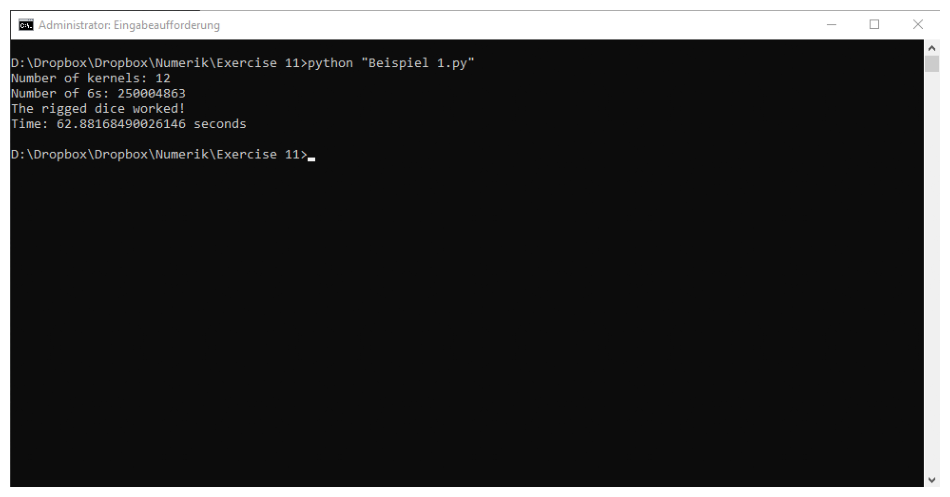

In [24]:
##Darstellung der Ergebnisse aus der Windows-Shell
import matplotlib.pyplot as plt
import matplotlib.image as img

im = img.imread('OutputBsp1.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)

## Code with Multiprocessing was ~30 times faster

# Exercise 2 - Calculate $\pi$

Using the **DSMC method**, calculate the value of **$\pi$**.


**Approach:**
In order to do this, create a 2-dimensional domain (defined by the coordinates $x_{min}, x_{max}, y_{min}, y_{max}$) and launch a number P of particles at random locations within. Check which particles lie inside a circle with radius $$ \frac{x_{max}-x_{min}}{2}, $$ where $x_{min}, x_{max}$ are the x-limits of your 2D domain. 

Get your value for $\pi$ by using the following formula:
$$\pi = \frac{4 \cdot n_{inside}}{P},$$ where $n_{inside}$ is the number of particles inside the circle and $P$ is the total number of particles.

Play around with the number of particles. 

**a)** Try to improve this task by making use of threading (you can use either the **_thread** or **threading** module). What are your findings, is the script running faster? 

**b)** Now try to improve the running time of the code by employing the **multiprocessing** module. Are there any differences as compared to threading?

In [15]:
import time
import math
import numpy as np

# Grenzen des Quadrats (frei wählbar, aber quadratisch!)
xmin = -2.0
xmax =  2.0
ymin = -2.0
ymax =  2.0

P = 10_000_000

# Sicherstellen, dass es wirklich ein Quadrat ist
assert (xmax - xmin) == (ymax - ymin), "xmin/xmax und ymin/ymax müssen ein Quadrat definieren!"

t0 = time.perf_counter()

rng = np.random.default_rng(12345)

# Zufällige Punkte im Quadrat
x = rng.uniform(xmin, xmax, size=P)
y = rng.uniform(ymin, ymax, size=P)

# Mittelpunkt und Radius
x_center = (xmin + xmax) / 2
y_center = (ymin + ymax) / 2
r = (xmax - xmin) / 2

# Punkte im Kreis zählen
inside = np.sum((x - x_center)**2 + (y - y_center)**2 <= r**2)

# Vorgabe aus dem Aufgabenblatt:
pi_est = 4 * inside / P

t1 = time.perf_counter()

print("Monte-Carlo-Schätzung von π")
print(f"P = {P:,}")
print(f"π_est = {pi_est:.10f}")
print(f"Fehler = {abs(pi_est - math.pi):.3e}")
print(f"Zeit = {t1 - t0:.3f} s")

Monte-Carlo-Schätzung von π
P = 10,000,000
π_est = 3.1408856000
Fehler = 7.071e-04
Zeit = 0.417 s


## Version des Codes mit Variation von P zur Visualisierung der Abhängigkeit der Laufzeit von P

Erwartung: Laufzeit t wächst linear mit P - Diagramm t vs P sollte Gerade sein (bei log-log-Skala)

P =    100,000 | π_est = 3.13784000 | Zeit = 0.0040 s
P =    300,000 | π_est = 3.14424000 | Zeit = 0.0120 s
P =  1,000,000 | π_est = 3.13850000 | Zeit = 0.0410 s
P =  3,000,000 | π_est = 3.14157067 | Zeit = 0.1220 s
P = 10,000,000 | π_est = 3.14154080 | Zeit = 0.4220 s


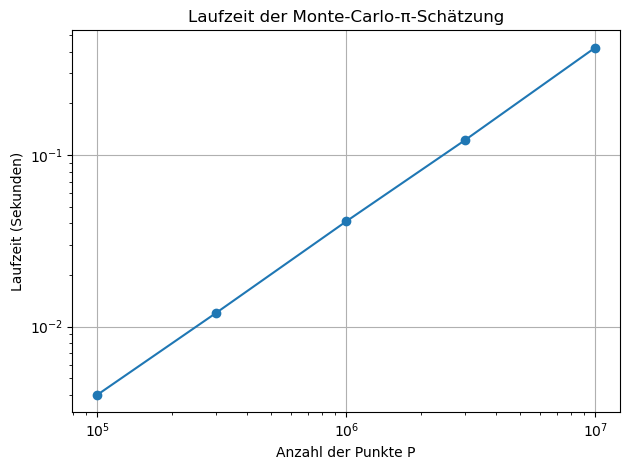

In [14]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt

#Definieren Quadrat
xmin = -1.0
xmax = 1.0
ymin = -1.0
ymax = 1.0

# Sicherstellen, dass es ein Quadrat ist, denn sonst funktioniert die Formel zu Berechnung von Pi aus der Angabe nicht
assert (xmax - xmin) == (ymax - ymin), "Grenzen müssen ein Quadrat definieren!"

# Mittelpunkt und Radius des eingeschriebenen Kreises berechnen
x_center = (xmin + xmax) / 2
y_center = (ymin + ymax) / 2
r = (xmax - xmin) / 2

#Liste mit Anzahl von zufällig verteilten Punkten erstellen
P_values = [100_000, 300_000, 1_000_000, 3_000_000, 10_000_000]

# Arrays für die Laufzeiten und Fehler initialisieren
times = []
errors = []

#Zufallszahlengenerator initialisieren
rng = np.random.default_rng(12345)

###
# Start der Montecarlo-Simulation

for P in P_values:
    t0 = time.perf_counter()

    # Zufallspunkte erzeugen
    x = rng.uniform(xmin, xmax, size=P)
    y = rng.uniform(ymin, ymax, size=P)

    # Punkte im Kreis zählen
    inside = np.sum((x - x_center)**2 + (y - y_center)**2 <= r**2)

    # Pi-Schätzung
    pi_est = 4 * inside / P

    t1 = time.perf_counter()

    # Werte speichern und an times/errors-Liste anhängen
    times.append(t1 - t0)
    errors.append(abs(pi_est - math.pi))

    print(f"P = {P:>10,} | π_est = {pi_est:.8f} | Zeit = {t1 - t0:.4f} s")

# Plot: Anzahl der Punkte vs Laufzeit
plt.figure()
plt.plot(P_values, times, marker="o")
plt.xlabel("Anzahl der Punkte P")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Laufzeit der Monte-Carlo-π-Schätzung")
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()

# Version with Threading

Was ist Threading?
 -------------------------
 Ein "Thread" ist ein Ausführungsstrang innerhalb *eines* Prozesses. Simpel gesagt: Das Programm wechselt schnell zwischen verschiedenen Aufgaben hin und her. Ist eher "Abwechselnd rechnen" statt "Parallel rechnen". 
 Das heißt:
   - Alle Threads teilen sich den gleichen Speicher (gleiche Variablen im Prozess).
   - Threads brauchen zum Start weniger Overhead als das Starten unterschiedlicher Prozesse
   - ABER: In CPython gibt es den GIL (Global Interpreter Lock).

Simpel gesagt: In CPython darf immer nur EIN Thread gleichzeitig Python-Bytecode ausführen. Wenn eh nur gerechnet wird, bringt Threading dann gar nix. Wenn aber viel Input/Output oder andere Kommunikation stattfindet, kann es sinnvoll sein. Wenn ein Thread gerade wartet, weil Daten eingelesen werden, weil irgendwas runtergeladen wird, usw, kann ein anderer weiterrechnen und die Wartezeit sinnvoll nutzen. 

 Warum dann hier Threading?
 ------------------------------------
 Weil wir NumPy verwenden:
   - NumPy macht viele Rechenoperationen in C (nicht in Python-Bytecode).
   - Bei solchen C-Operationen kann der GIL teilweise freigegeben werden.

Erwartung:
 -----------------------
 Threading kann hier helfen, muss aber nicht und wird es wahrscheinlich auch nicht. 



In [ ]:
## ACHTUNG: Code nicht in Jupyter Notebook Online ausführen; gibt Fehlermeldung. 
## Siehe weiter unten für die Ergebnisse des Programms

import time
import math
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


#Definieren Quadrat
xmin = -1.0
xmax = 1.0
ymin = -1.0
ymax = 1.0

# Sicherstellen, dass es ein Quadrat ist, denn sonst funktioniert die Formel zu Berechnung von Pi aus der Angabe nicht
assert (xmax - xmin) == (ymax - ymin), "Grenzen müssen ein Quadrat definieren!"

# Mittelpunkt und Radius des eingeschriebenen Kreises berechnen
x_center = (xmin + xmax) / 2
y_center = (ymin + ymax) / 2
r = (xmax - xmin) / 2


def mc_inside_count(P, seed):
    #Workerfunktion für einen Thread 
    #Input ist die Zahl der Zufallspunkte P im Quadrat 
    #UND außerdem ein seed für den Zufallsgenerator, damit jeder Thread seine eigenen Zufallszahlen hat
    
    rng = np.random.default_rng(seed)

    # Zufallspunkte im Quadrat
    x = rng.uniform(xmin, xmax, size=P)
    y = rng.uniform(ymin, ymax, size=P)

    # Zähle Punkte im Kreis
    inside = np.sum((x - x_center) ** 2 + (y - y_center) ** 2 <= r ** 2)

    #Rückgabe sind Punkte im Kreis
    return int(inside)


def pi_threading(P_total, threads, base_seed) :
    # Eigene Funktion zur Berechnung von Pi mit Threading
    # Nicht als Hauptprogramm, damit es später einfacher wird, den Plot P vs. Laufzeit zu erstellen
    # Grundidee: Teilen die gesamte Zahl P_total der Zufallspunkte in ca gleich große Stücke auf
    # Jeder Thread rechnet dann die "inside"-Zahl für sein Stück auf
    # Am Ende wird alles summiert

    # P_total gleichmäßig auf gewählte Anzahl der threads aufteilen. Jeder thread kriegt P_thread Punkte zum arbeiten
    # Werden in Liste "parts" gespeiechert
    P_thread = P_total // threads
    parts = [P_thread] * threads

    # Wenn ein Rest bleibt, werden diese Punkte auf die Threads verteilt
    
    rest = P_total % threads
    for i in range(rest):
        parts[i] += 1
    
    # Für unabhängige Zufallszahlen: pro Thread ein eigener Seed
    # Liste mit seeds ist einfach baseseed + 1, für jeden Thread eins weitergezählt
    seeds = [base_seed + i for i in range(threads)]

    #Ergebnisvariable auf Null setzen
    
    inside_total = 0

    #Threadingteil
    # ThreadPoolExecutor() startet Threads innerhalb des aktuellen Prozesses.
    # ex.map ruft mc_inside_count(part, seed) für jedes Paar parallel auf.
    # Ist formal vergleichbar mit Pool() aus Bsp 1., nur hier jetzt ThreadPoolExecutor()
    # Und ex.map() statt pool.map
    # Für jeden Thread wird die Workerfunktion aufgerufen, mit den jeweiligen Argumenten aus parts und seeds
    # Die Ergebnisse jedes Threads werden in "inside" gespeichert und am Ende aufsummiert
    with ThreadPoolExecutor(max_workers=threads) as ex:
        for inside in ex.map(mc_inside_count, parts, seeds):
            inside_total += inside

    # Berechnung von Pi
    pi_est = 4.0 * inside_total / P_total
    return pi_est


###
# Berechnung von Pi mit Threading für verschiedene Werte von P
P_values = [100_000, 300_000, 1_000_000, 3_000_000, 10_000_000]
threads = 8  # Anzahl der Threads

# Arrays für die Laufzeiten und Fehler initialisieren
times_thread = []
errors_thread = []

###
# Start der Montecarlo-Simulation
for P in P_values:
    t0 = time.perf_counter()

    pi_est = pi_threading(P_total=P, threads=threads, base_seed=12345)

    t1 = time.perf_counter()

    times_thread.append(t1 - t0)
    errors_thread.append(abs(pi_est - math.pi))

    print(f"[threading] P = {P:>10,} | π_est = {pi_est:.8f} | Zeit = {t1 - t0:.4f} s")


##Ergebnus Plotten
plt.figure()
plt.plot(P_values, times_thread, marker="o")
plt.xlabel("Anzahl der Punkte P")
plt.ylabel("Laufzeit (Sekunden)")
plt.title(f"Laufzeit der Monte-Carlo-π-Schätzung (Threading, threads={threads})")
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()

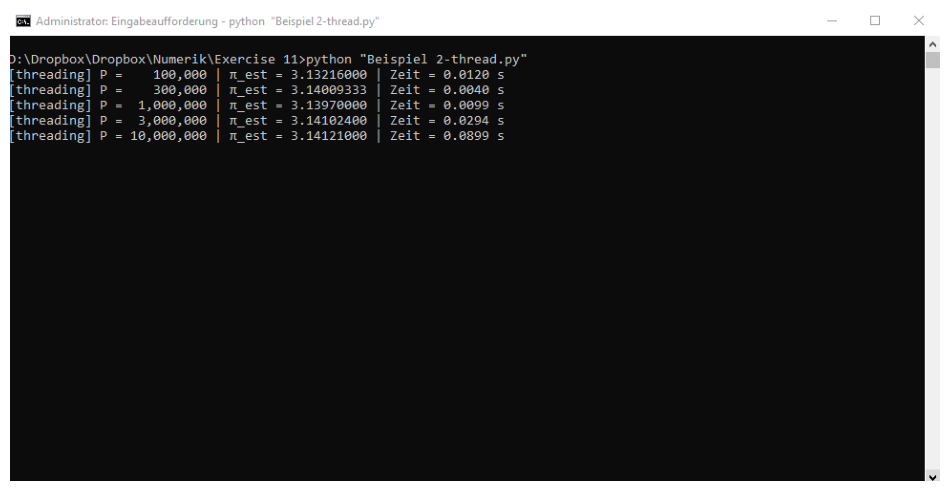

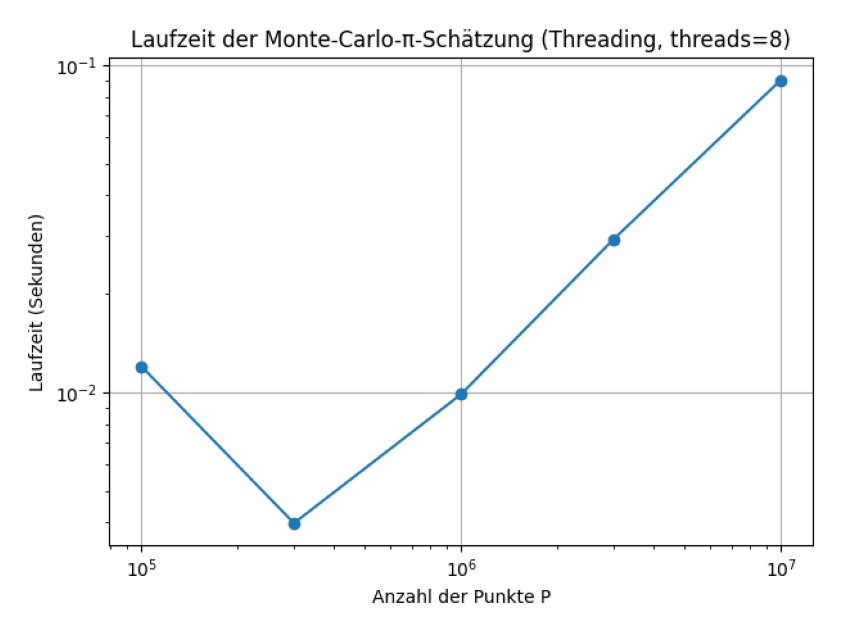

In [51]:
##Darstellung der Ergebnisse aus der Windows-Shell
import matplotlib.pyplot as plt
import matplotlib.image as img

im = img.imread('OutputBsp2-1.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)

im = img.imread('OutputBsp2-2.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)

# Vergleich mit/ohne Threading

Bei P=10.000.000 ist der Code mit Threading ca 4 mal schneller. Hier dominiert im Code das Rechnen (und die Berechnung der Zufallszahlen) und der Overhead für das Management der Threads ist vergleichsweise klein. 

Bei kleineren P, zB P=100.000 ist der Threadingcode ca 3 mal langsamer. Hier ist der Overhead vergleichsweise groß. Die Threads müssen gestartet und verwaltet werden; Aufgaben müssen verteilt werden, Ergebnisse eingesammelt werden, usw. 

Außerdem: Threadingcode ist für P=300.000 schneller als für P=100.000. Liegt vermutlich daran, dass das "Rauschen"
bei der Messung solcher kurzen Zeiten recht groß ist. 

Fazit: Threading lohnt sich  erst bei großen P; bei kleinen P kann Threading sogar kontraproduktiv sein

# Version with Multiprocessing


In [ ]:
## ACHTUNG: Code nicht in Jupyter Notebook Online ausführen; gibt Fehlermeldung. 
## Siehe weiter unten für die Ergebnisse des Programms

import time
import math
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

# Definieren Quadrat
xmin = -1.0
xmax = 1.0
ymin = -1.0
ymax = 1.0

# Sicherstellen, dass es ein Quadrat ist, denn sonst funktioniert die Formel zu Berechnung von Pi aus der Angabe nicht
assert (xmax - xmin) == (ymax - ymin), "Grenzen müssen ein Quadrat definieren!"

# Mittelpunkt und Radius des eingeschriebenen Kreises berechnen
x_center = (xmin + xmax) / 2
y_center = (ymin + ymax) / 2
r = (xmax - xmin) / 2


def mc_inside_count(args):
    # Workerfunktion für einen Prozess
    # Input ist die Zahl der Zufallspunkte P im Quadrat
    # UND außerdem ein seed für den Zufallsgenerator, damit jeder Prozess seine eigenen Zufallszahlen hat
    # Werden in Tupel "args" übergeben und dann in Variablen transformiert

    P, seed = args 
    
    rng = np.random.default_rng(seed)

    # Zufallspunkte im Quadrat
    x = rng.uniform(xmin, xmax, size=P)
    y = rng.uniform(ymin, ymax, size=P)

    # Zähle Punkte im Kreis
    inside = np.sum((x - x_center) ** 2 + (y - y_center) ** 2 <= r ** 2)

    # Rückgabe sind Punkte im Kreis
    return int(inside)


def pi_multiprocessing(P_total, processes, base_seed):
    # Eigene Funktion zur Berechnung von Pi mit Multiprocessing
    # Nicht als Hauptprogramm, damit es später einfacher wird, den Plot P vs. Laufzeit zu erstellen
    # Grundidee: Teilen die gesamte Zahl P_total der Zufallspunkte in ca gleich große Stücke auf
    # Jeder Prozess rechnet dann die "inside"-Zahl für sein Stück auf
    # Am Ende wird alles summiert

    # P_total gleichmäßig auf gewählte Anzahl der Prozesse aufteilen. Jeder Prozess kriegt P_proc Punkte zum arbeiten
    # Werden in Liste "parts" gespeichert
    P_proc = P_total // processes
    parts = [P_proc] * processes

    # Wenn ein Rest bleibt, werden diese Punkte auf die Prozesse verteilt

    rest = P_total % processes
    for i in range(rest):
        parts[i] += 1

    # Für unabhängige Zufallszahlen: pro Prozess ein eigener Seed
    # Liste mit seeds ist einfach base_seed + 1, für jeden Prozess eins weitergezählt
    seeds = [base_seed + i for i in range(processes)]

    # Ergebnisvariable auf Null setzen
    inside_total = 0

    # Multiprocessingteil
    # analog zu Bsp 1
    # verbinden parts und seed mit zip() zu Tupel, damit sie an pool.map() übergeben werden kann
    
    with mp.Pool(processes=processes) as pool:
       results = pool.map(mc_inside_count, zip(parts, seeds))

    # Ergebnisse aufsummieren
    inside_total = sum(results)

    # Berechnung von Pi
    pi_est = 4.0 * inside_total / P_total
    return pi_est


def main():
    # Hauptprogramm, braucht man bei Multiprocessing als eigene "Funktion" main() (siehe Kommentar am Ende des Programms)
    ###
    # Berechnung von Pi mit Multiprocessing für verschiedene Werte von P
    P_values = [100_000, 300_000, 1_000_000, 3_000_000, 10_000_000]
    # Anzahl der Prozesse fix als 8 (zum Vergleichen mit Threads)
    processes = 8  
    #Ansonsten Prozesse anhand CPU-Kernel setzen
    #processes=mp.cpu_count()
    
    # Arrays für die Laufzeiten und Fehler initialisieren
    times_mp = []
    errors_mp = []

    ###
    # Start der Montecarlo-Simulation
    for P in P_values:
        t0 = time.perf_counter()

        pi_est = pi_multiprocessing(P_total=P, processes=processes, base_seed=12345)

        t1 = time.perf_counter()

        times_mp.append(t1 - t0)
        errors_mp.append(abs(pi_est - math.pi))

        print(f"[multiprocessing] P = {P:>10,} | π_est = {pi_est:.8f} | Zeit = {t1 - t0:.4f} s")

    ## Ergebnis Plotten
    plt.figure()
    plt.plot(P_values, times_mp, marker="o")
    plt.xlabel("Anzahl der Punkte P")
    plt.ylabel("Laufzeit (Sekunden)")
    plt.title(f"Laufzeit der Monte-Carlo-π-Schätzung (Multiprocessing, processes={processes})")
    plt.grid(True)
    plt.xscale("log")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

# Die Zeilen "if __name__ == "__main__": main()) sind hier nötig, damit es keine Probleme mit multiprocessing gibt
# Sie besagen: Führe den Code in main() nur aus, wenn das Programm direkt gestartet wird, nicht, wenn es von irgendwo importiert wird.
# Der Hauptprozess erstellt ja einen Pool von neuen Prozessen, die das ganze Programm importieren und die sollen nicht wieder einen neuen Pool erzeugen
# Mit "if __name__ == "__main__":" wird sichergestellt, dass die Pool-Prozesse nur die Worker-Funktionen ausführen 
if __name__ == "__main__":
    main()


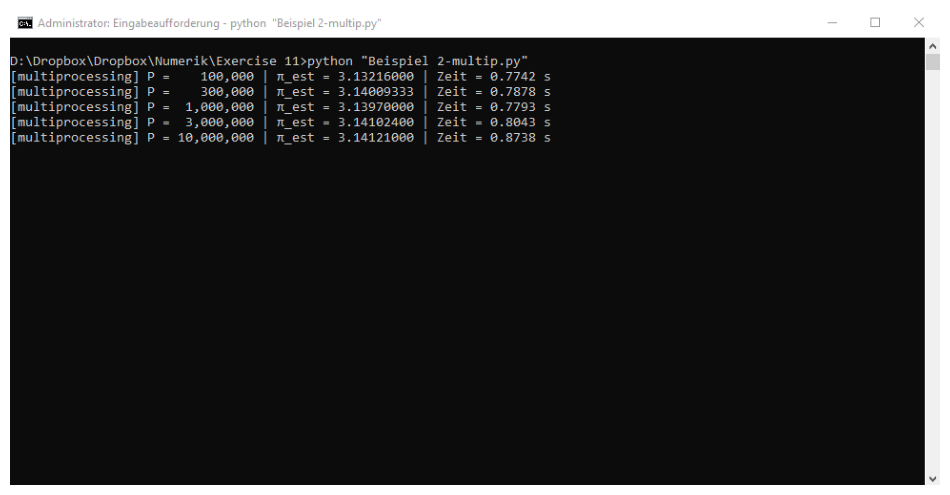

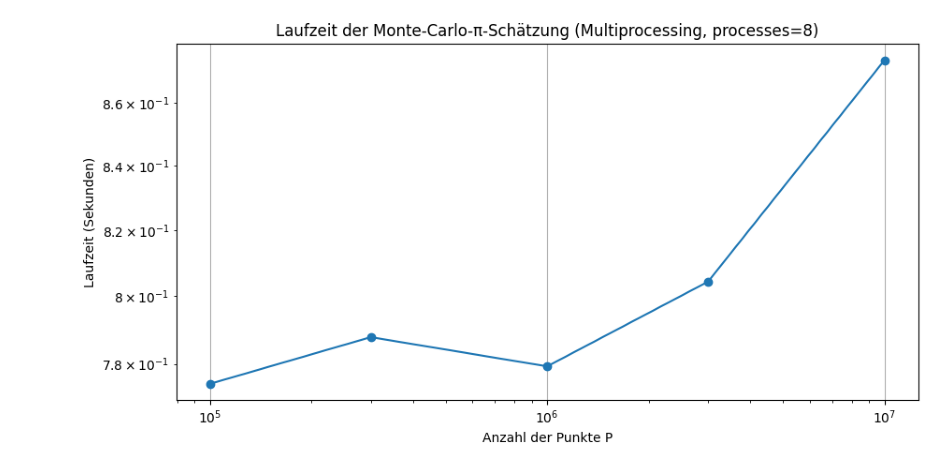

In [55]:
##Darstellung der Ergebnisse aus der Windows-Shell
import matplotlib.pyplot as plt
import matplotlib.image as img

im = img.imread('OutputBsp2-3.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)

im = img.imread('OutputBsp2-4.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)

# Vergleich Threading/Multiprocessing

Die serielle Version wird mit wachsendem P stetig langsamer. Die Threading-Version ist deutlich schneller als die serielle, weil die NumPy-Operationen in optimiertem C-Code ausgeführt werden und dabei mehrere CPU-Kerne parallel genutzt werden können. Dadurch lohnt sich Threading, obwohl Python normalerweise durch den Global Interpreter Lock (GIL) eingeschränkt ist. Die Multiprocessing-Version ist hier sogar noch langsamser als Threading. Der Grund dafür ist der hohe Overhead beim Starten und Verwalten der Prozesse sowie bei der Kommunikation zwischen den Prozessen. Dieser Overhead dominiert die Laufzeit, insbesondere wenn pro Prozess nur vergleichsweise wenig Arbeit anfällt. Deshalb bleibt die Laufzeit beim Multiprocessing nahezu konstant, unabhängig davon, wie groß P ist. Threading hat deutlich weniger Overhead, da alle Threads im selben Prozess laufen und sich den Speicher teilen. Multiprocessing lohnt sich vor allem dann, wenn sehr viel reine Python-Arbeit (z.B. lange Schleifen) pro Task anfällt. Hier, wo sehr viel NumPy verwendet wird, scheint  Threading daher die effizienteste Variante zu sein. 



# Exercise 3 - Mandelbrot fractals

Read about the Mandelbrot set: https://en.wikipedia.org/wiki/Mandelbrot_set. 
This set is defined by repeatedly applying this recurrence:

$z_{n+1} = z_{n}^2 + c$,

which starts with $z_{0} = 0$ for a given complex number $c$ (each pixel corresponds to one $c$). The idea is to check if a particle "escapes" at a certain iteration. At each iteration, one checks if the sequence $z_0, z_1, ... z_n$ growing or stays bound. The growing condition: $|z_n| > 2$. If the condition ```if (z.real*z.real + z.imag*z.imag) > 4``` is fulfilled at any step, we mark the particle as "escaped". If the sequence stays bound forever (never uncontrollably grows for a given number of iterations, for instance, 300), then it is inside the the Mandelbrot set.

**(A)** Create a script which visualizes the Mandelbrot set. The X-axis is the real part of the complex number, the Y-axis is the imaginary part. You can use the colorscheme of your choice. Mark the particles which never escape as one color, and color the escaped particles based on how fast they escaped (that is, use the iteration at which they escaped for your colorbar). You should define the width and height of your image (for instance, 1000 and 700, but you can change it if you like), and 

**(B)** Parallelize your Mandelbrot function using the *multiprocessing* module. Experiment with different sizes of datachunks you give separate processors (you can split the data by column chunks or row chunks and process them separately in separate processes).



Time: 3.201 s


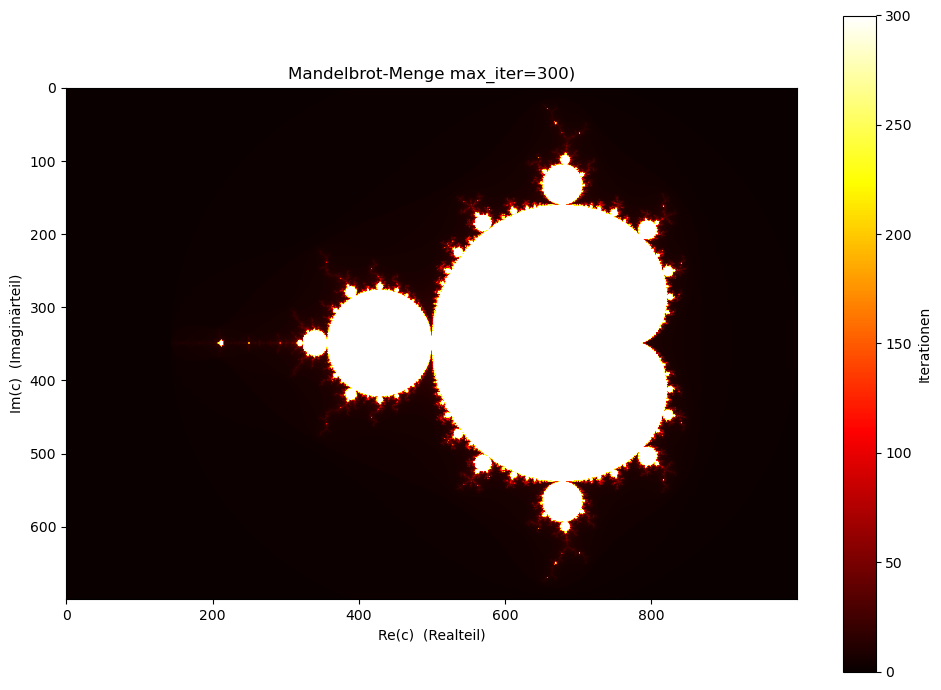

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Bildgröße (laut Angabe)
width = 1000
height = 700

# Maximale Iterationen
max_iter = 300

# Ausschnitt der dargestellt werden soll (x-Achse Realteil, y-Achse Imaginärteil)
re_min, re_max = -2.5, 1.0
im_min, im_max = -1.2, 1.2

###
#Vorbereitungen für die Berechnung

# Erzeugen Gitter C mit einer komplexen Zahl pro Pixel
# Zuerst Punkte entlang Real/Imaginär-Achse (x/y) erzeugen

x = np.linspace(re_min, re_max, width)
y = np.linspace(im_min, im_max, height) 

# Dann aus beiden 1D-Arrays ein 2D-Gitter erzeugen. 
# x und y haben aber unterschiedliche Längen (weil width und height unterschiedlich sind)
# --> können nicht einfach kombiniert werden. 
# x sollen die Zeilen sein, y die Spalten und dazwischen brauchen wir überall Wert
# --> np.meshgrid() macht das

Re, Im = np.meshgrid(x, y)
C = Re + 1j * Im

# Müssen Gitter mit Startwerten erzeugen. Gleiches Gitter wie C, nur voll mit Nullen (z0=0)
Z = np.zeros_like(C)

# Müssen speicher, wann bei einem Pixel im Gitter die Iteration den Grenzwert überschreitet.
# Brauchen noch ein Gitter, wo für jeden Pixel die entsprechende Iterationszahl drin steht
# Zu Beginn soll überall max_iter stehen. Die Werte werden dann bei der Berechnung durch die passenden Werte ersetzt
# Gitter wie Z (oder C), mit "max_iter" gefüllt --> np.full_like()

Escaped_at = np.full_like(Z, max_iter, dtype=int)

# Wollen außerdem noch wissen: Bei welchem Pixel ist die Iteration schon durch (Grenzwert überschritten) und wo nicht?
# Noch ein Gitter, aber jetzt nur gefüllt mit "1" (Iteration läuft noch) oder "0" (Grenzwert überschritten) 
# Beziehungsweise "True"/"False"-Werte statt 1 und 0.
# Zu Beginn soll überall "1" stehen, weil die Iteration noch nirgendwo zu Ende sein kann

Aktiv = np.ones_like(Z, dtype=bool)

###
# Jetzt Berechnung der Mandelbrot-Menge
# Ist definiert als Menge aller komplexen Zahlen c auf dem Gitter C für die die Iteration:
# z_(n+1) = z_n^2 + c mit dem Startwert z0=0 
# einen Grenzwert nicht überschreitet
# Grenzwert (laut Angabe): Realteil(z)^2 + Imaginärteil(z)^2) > 4
# Führen die Iteraton max_iter mal aus. Wenn z_(n+1) irgendwann den Grenzwert überschreitet, ist die zugehörige Zahl c nicht Teil der Mandelbrotmenge
# Speichern für jede Zahl ob sie Teil der Menge ist und wenn nicht, wie viele Iterationen es gebraucht hat, bis der Grenzwert überschritten wurde
# 
# Wenn wir das Gitter "Aktiv" als Maske für Z und C verwenden, können wir gezielt nur die Iterationen rechnen, die noch nötig sind.
# Z[active] spricht nur die Startwerte an, wo der Grenzwert noch nicht überschritten wurde --> effektivere Berechnung

t0 = time.perf_counter()

for i in range(max_iter):
    # Nur für die Punkte weiterrechnen, die noch aktiv sind
    # Wir lassen die Iteration simulation über das gesamte Gitter laufen
    Z[Aktiv] = Z[Aktiv] * Z[Aktiv] + C[Aktiv]

    # Test ob Grenzwert überschritten
    # Gitter "Grenze" gibt für jeden Punkt den aktuellen Wert der Grenzbedingung
    Grenze = Z.real * Z.real + Z.imag * Z.imag

    # Schauen in Gitter "Aktiv" nach, ob ein Punkt noch aktiv ist UND gleichzeitig der Grenzwert überschritten wurde
    # Wenn beides zutrifft, gibt es im Gitter "Over" einen Eintrag "True", ansonsten "False"
    Over = Aktiv & (Grenze > 4.0)

    # Dort wo im Gitter "Over" "true" steht, tragen wir den Wert von i ein, bei dem der Grenzwert überschritten wurde
    Escaped_at[Over] = i

    # Außerdem sind diese Werte jetzt nicht mehr aktiv und wir müssen den Eintrag in "Aktiv" ändern. 
    Aktiv[Over] = False


t1 = time.perf_counter()
print(f"Time: {t1 - t0:.3f} s")

###
# Plotten der Mandelbrotmenge
# Die relevanten Daten stehen in Gitter "Escaped_at"
# Da wo dort immer noch der Eintrag "max_iter" steht, ist der Grenzwert nie überschritten worden:
# --> diese Gitterpunkte sind Teil der Mandelbrotmenge
# Da wo eine Zahl steht, die kleiner als max_iter ist, ist der Grenzwert überschritten worden:
# --> zeichnen Pixel mit Farbe, je nachdem wie groß/klein die Zahl ist dh. je nachdem, wie schnell die Überschreitung passiert ist


plt.figure(figsize=(10, 7))

# 2D-Daten mit Colormap plotten --> macht Funktion imshow()

mandelbrot=plt.imshow(Escaped_at, cmap="hot")
cbar = plt.colorbar(mandelbrot)
cbar.set_label("Iterationen")
plt.xlabel("Re(c)  (Realteil)")
plt.ylabel("Im(c)  (Imaginärteil)")
plt.title(f"Mandelbrot-Menge max_iter={max_iter})")
plt.tight_layout()
plt.show()

# Version with Multiprocessing


In [ ]:
## ACHTUNG: Code nicht in Jupyter Notebook Online ausführen; gibt Fehlermeldung. 
## Siehe weiter unten für die Ergebnisse des Programms

import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing as mp

#Parameter für das Bild
width = 1000
height = 700
max_iter = 300
re_min, re_max = -2.5, 1.0
im_min, im_max = -1.2, 1.2



def mandelbrot_row_block(args):
    #Worker-Funktion die die Mandelbrotmenge für die Zeilen von y0 bis y1 berechnet
    #Braucht außerdem noch die restlichen Infos über das Bild:
    #width, height und max_iter
    #re_min, re_max, im_min und im_max
    #Werden an die Worker-funktion im Tupel "args" übergeben und dann daraus in die einzelnen Variablen transformiert
    
    (y0, y1, width, height, max_iter, re_min, re_max, im_min, im_max) = args

    #Ab hier Berechnung der Mandelbrotmenge analog zum seriellen Code oben.
    #Wichtiger Unterschied: Aus dem 1D-Array für die Punkte auf der y-Achse (Reihen) nehmen wir nur die Reihen raus, die zwischen y0 und y1 liegen!
    
    x = np.linspace(re_min, re_max, width)
    y_full = np.linspace(im_min, im_max, height)
    y = y_full[y0:y1]

    Re, Im = np.meshgrid(x, y)
    C = Re + 1j * Im

    Z = np.zeros_like(C)
    Escaped_at = np.full_like(Z, max_iter, dtype=int)
    Aktiv = np.ones_like(Z, dtype=bool)

    for i in range(max_iter):
        Z[Aktiv] = Z[Aktiv] * Z[Aktiv] + C[Aktiv]
        Grenze = Z.real * Z.real + Z.imag * Z.imag
        Over = Aktiv & (Grenze > 4.0)
        Escaped_at[Over] = i
        Aktiv[Over] = False

    #Workerfunktion gibt die passenden Punkte im Gitter "Escaped_at" zurück und außerdem nochmal y0, damit das Hauptprogramm weiß, wo dieser Chunk am Ende hingehört

    return y0, Escaped_at



def main():
    # Hauptprogramm, braucht man bei Multiprocessing als eigene "Funktion" main() (siehe Kommentar am Ende des Programms)
    ### Aufteilung der Berechnung in Chunks
    #Benutzen so viele Prozesse, wie CPU-Kernels existieren
    kernels = mp.cpu_count()
    print("Number of kernels:", kernels)
    
    # Aufteilung der Reihen im Bild in chunks für die einzelnen Prozesse
    # Größe der chunks hängt von den kernels ab
    # Anzahl der chunks von der chunk_size
    # zB N=1000, kernel=5 --> chunk_size= 200 und es gibt 5 chunks mit je 200 Würfen
    # Bei der Mandelbrotmenge ist N die Anzahl der Zeilen im Bild/Gitter ("height")
    N = height  
    chunk_size = N // kernels
    full_chunks = N // chunk_size
    
    #Liste mit der Anzahl der Reihen für den jeweiligen chunks, die dann an die worker-Funktion übergeben wird 
    row_sizes = [chunk_size] * full_chunks

    # Es kann sein, dass bei der Aufteilung ein Rest bleibt. Der wird dann als kleinerer extra chunk angehängt
    rest = N % chunk_size
    if rest > 0:
        row_sizes.append(rest)

    # Stellen Liste mit Argumenten für die Workerfunktion zusammen
    tasks = []
    y0 = 0
    for rows in row_sizes:
        y1 = y0 + rows
        tasks.append((y0, y1, width, height, max_iter, re_min, re_max, im_min, im_max))
        y0 = y1



    ####
    # Parallelisierung der Berechnung
    # Erstellen zuerst ein Gitter, das mit beliebigen Werten gefüllt ist
    Escaped_at_full = np.full((height, width), max_iter, dtype=int)

    t0 = time.perf_counter()

    # Pool() erzeugt mehrere Prozesse
    # pool = mp.Pool(processes=kernels) bedeutet: 
    # Starte mehrere Python-Prozesse (so viel wie die Variable "kernel" angibt) und halte sie bereit, um Aufgaben zu erledigen
    # Kommando verwenden mit "with.. as", damit der Pool am Ende geschlossen wird und keine Zombie-Prozesse übrig bleiben

    # Jeder Prozess ruft eine eigene worker-Funktion auf, mit dem jeweiligen Argument aus der throws-Liste
    # Funktion pool.map() analog zu normaler map()-Funktion in Python (führt eine Funktion mehrmals für eine Liste von Argumenten aus)
    # results enthält dann die Liste result = [result1, result2, result3]
    # Rufen Mandelbrot-Workerfunktion für die Liste der Argumente aus tasks auf
    # Ergebnisse sind jeweils y0 (bei welcher Reihe fängt der Chunk an?) und ein Gitter "block" mit dem Ausschnitt der Mandelbrotmenge
    
    with mp.Pool(processes=kernels) as pool:
        results = pool.map(mandelbrot_row_block, tasks)

    # Bild wird zusammengesetzt
    for y0, block in results:

        #Wie viele Zeilen hat der aktuelle Block?
        rows_in_block=block.shape[0]

        #Nimm alle Zeilen von y0,y0+rows_in_block aus dem Gitter Escaped_at_full und nimm alle Spalten und setze dort den Inhalt von "block" rein
        Escaped_at_full[y0:y0 + rows_in_block, :] = block

    t1 = time.perf_counter()
    print(f"Time {t1 - t0:.3f} s  (kernels={kernels}, chunk_size={chunk_size})")

    ###
    # Plotten der Mandelbrotmenge
    # Die relevanten Daten stehen in Gitter "Escaped_at"
    # Da wo dort immer noch der Eintrag "max_iter" steht, ist der Grenzwert nie überschritten worden:
    # --> diese Gitterpunkte sind Teil der Mandelbrotmenge
    # Da wo eine Zahl steht, die kleiner als max_iter ist, ist der Grenzwert überschritten worden:
    # --> zeichnen Pixel mit Farbe, je nachdem wie groß/klein die Zahl ist dh. je nachdem, wie schnell die Überschreitung passiert ist

    mandelbrot=plt.imshow(Escaped_at_full, cmap="hot")
    cbar = plt.colorbar(mandelbrot)
    cbar.set_label("Iterationen")
    plt.xlabel("Re(c)  (Realteil)")
    plt.ylabel("Im(c)  (Imaginärteil)")
    plt.title(f"Mandelbrot-Menge max_iter={max_iter})")
    plt.tight_layout()
    plt.show()
    
# Die Zeilen "if __name__ == "__main__": main()) sind hier nötig, damit es keine Probleme mit multiprocessing gibt
# Sie besagen: Führe den Code in main() nur aus, wenn das Programm direkt gestartet wird, nicht, wenn es von irgendwo importiert wird.
# Der Hauptprozess erstellt ja einen Pool von neuen Prozessen, die das ganze Programm importieren und die sollen nicht wieder einen neuen Pool erzeugen
# Mit "if __name__ == "__main__":" wird sichergestellt, dass die Pool-Prozesse nur die Worker-Funktionen ausführen 
if __name__ == "__main__":
    main()


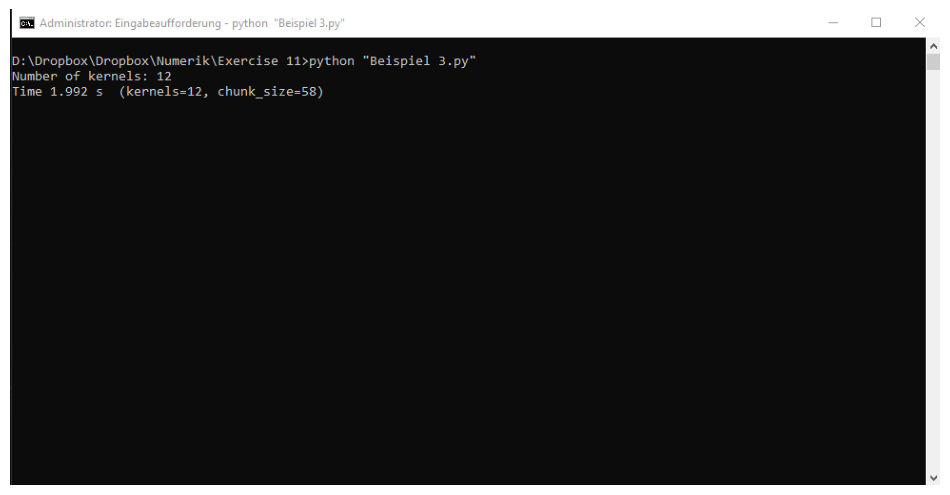

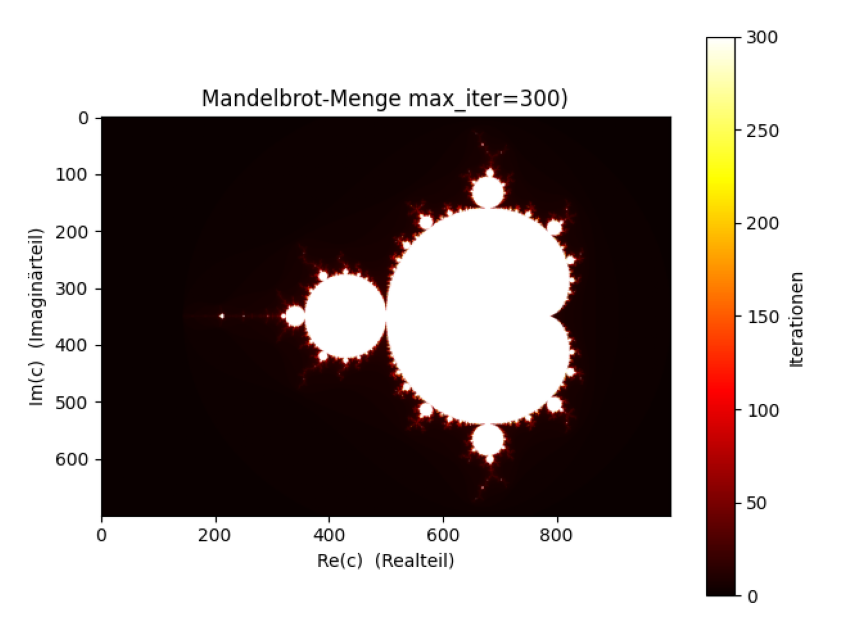

In [48]:
##Darstellung der Ergebnisse aus der Windows-Shell
import matplotlib.pyplot as plt
import matplotlib.image as img

im = img.imread('OutputBsp3-1.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)

im = img.imread('OutputBsp3-2.png')

plt.figure(figsize=(12, 8))  
plt.imshow(im)
plt.axis('off')       
plt.imshow(im)